In [2]:
from pytorch_model import load_wpod
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms, utils, models
from torch import nn
import torch
from src.label import Label, Shape
from src.utils import getWH, nms, im2single, IOU_centre_and_dims
from src.projection_utils import getRectPts, find_T_matrix
import time
from utils import *
from tqdm import tqdm
#import darknet.python.darknet as dn

In [3]:
wpod_net = load_wpod()
wpod_net.to(device)
wpod_net.eval()
lp_threshold = .5

In [4]:
def get_ocr(count):
    ocr_threshold = .4

    ocr_weights = bytes('data/ocr/ocr-net.weights', encoding="utf-8")
    ocr_netcfg  = bytes('data/ocr/ocr-net.cfg', encoding="utf-8")
    ocr_dataset = bytes('data/ocr/ocr-net.data', encoding="utf-8")

    ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
    ocr_meta = dn.load_meta(ocr_dataset)

    imgs_path = bytes('./temp/lp'+str(count)+'.jpg', encoding="utf-8")

    bname = basename(splitext(img_path)[0])

    R = detect(ocr_net, ocr_meta, imgs_path ,thresh=ocr_threshold, nms=None)

    if len(R):

        L = dknet_label_conversion(R,240,80)
        L = nms(L,.45)

        L.sort(key=lambda x: x.tl()[0])
        lp_str = ''.join([chr(l.cl()) for l in L])

        return lp_str
    return ""
class DLabel (Label):

    def __init__(self,cl,pts,prob):
        self.pts = pts
        tl = np.amin(pts,1)
        br = np.amax(pts,1)
        Label.__init__(self,cl,tl,br,prob)

In [6]:
def reconstruct(Iorig,I,Y,out_size,threshold=.9):

    net_stride 	= 2**4
    side = ((208. + 40.)/2.)/net_stride # 7.75
    
    Probs = Y[...,0]
    Affines = Y[...,2:]
    rx,ry = Y.shape[:2]
    ywh = Y.shape[1::-1]
    iwh = np.array(I.shape[1::-1],dtype=float).reshape((2,1))
    xx,yy = np.where(Probs>threshold)
    
    WH = getWH(I.shape)
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha

    base = lambda vx,vy: np.matrix([[-vx,-vy,1.],[vx,-vy,1.],[vx,vy,1.],[-vx,vy,1.]]).T
    labels = []

    for i in range(len(xx)):
        y,x = xx[i],yy[i]
        affine = Affines[y,x]
        prob = Probs[y,x]
        mn = np.array([float(x) + .5,float(y) + .5])
        A = np.reshape(affine,(2,3))
        A[0,0] = max(A[0,0],0.)
        A[1,1] = max(A[1,1],0.)
        pts = np.array(A*base(vxx,vyy)) #*alpha
        pts_MN_center_mn = pts*side
        pts_MN = pts_MN_center_mn + mn.reshape((2,1))

        pts_prop = pts_MN/MN.reshape((2,1))

        labels.append(DLabel(0,pts_prop,prob))

    final_labels = nms(labels,.1)
    TLps = []

    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for i,label in enumerate(final_labels):

            t_ptsh 	= getRectPts(0,0,out_size[0],out_size[1])
            ptsh 	= np.concatenate((label.pts*getWH(Iorig.shape).reshape((2,1)),np.ones((1,4))))
            H 		= find_T_matrix(ptsh,t_ptsh)
            Ilp 	= cv2.warpPerspective(Iorig,H,out_size,borderValue=.0)

            TLps.append(Ilp)

    return final_labels,TLps
def imstat(im, threshold):
    Ivehicle = cv2.imread(im)
    plt.imshow(Image.open(im))
    plt.show()
    ratio = float(max(Ivehicle.shape[:2]))/min(Ivehicle.shape[:2])
    side  = int(ratio*288.)
    max_dim = min(side + (side%(2**4)),608)
    I = im2single(Ivehicle)
    net_step = 2**4
    min_dim_img = min(I.shape[:2])
    factor 		= float(max_dim)/min_dim_img

    w,h = (np.array(I.shape[1::-1],dtype=float)*factor).astype(int).tolist()
    w += (w%net_step!=0)*(net_step - w%net_step)
    h += (h%net_step!=0)*(net_step - h%net_step)
    Iresized = cv2.resize(I,(w,h))

    Tn = Iresized.copy()
    Tn = Tn.reshape((1,Tn.shape[0],Tn.shape[1],Tn.shape[2]))
    Tn = torch.tensor(Tn, device=device).permute(0,3,1,2)
    Yr = wpod_net(Tn).permute(0,2,3,1)[0].cpu().detach().numpy()
    Probs = Yr[...,0]
    acc = np.amax(Probs)
    print("Acc is {}%\n".format(round(100*acc,4)))
    L,TLps = reconstruct(Ivehicle,Iresized,Yr,(240,80),threshold)
    if len(TLps):
        Ilp = TLps[0]
        Ilp = cv2.cvtColor(Ilp, cv2.COLOR_BGR2GRAY)
        Ilp = cv2.cvtColor(Ilp, cv2.COLOR_GRAY2BGR)
        cv2.imwrite('./temp/lp'+str(i)+'.jpg',255*Ilp)
        #ocr_text = get_ocr(i)
        #print(ocr_text)
        #rec_chars = len([t for t in "BGJ6974" if t in ocr_text])
        rec_chars = 0
    else:
        rec_chars = 0
    return acc,rec_chars

lpillum


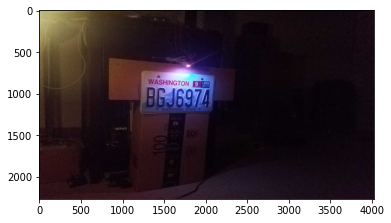

Acc is 99.9968%

ambientlp/amb200_0


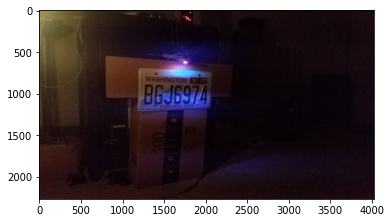

Acc is 99.9913%

ambientlp/amb200_1


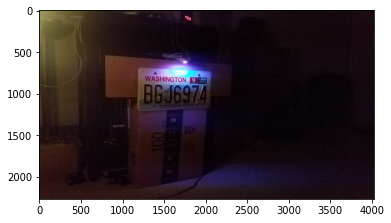

Acc is 3.001%

ambientlp/amb200_2


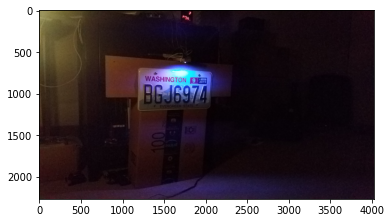

Acc is 99.8653%

ambientlp/amb200_3


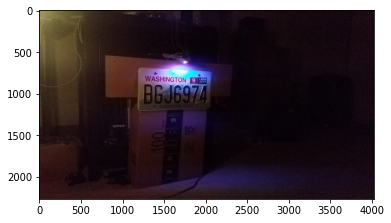

Acc is 8.3338%

ambientlp/amb200_4


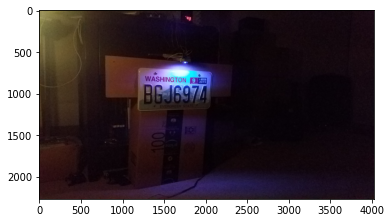

Acc is 89.2046%

ambientlp/amb200_5


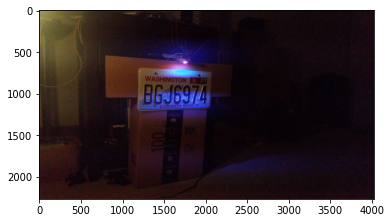

Acc is 99.9925%

ambientlp/amb200_6


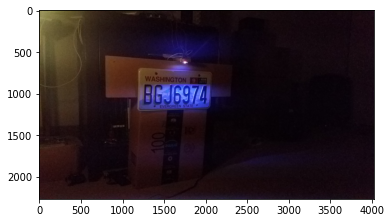

Acc is 99.9967%

ambientlp/amb200_7


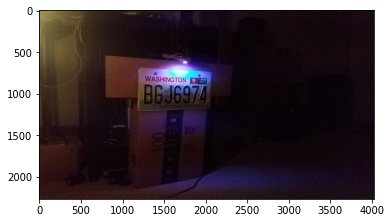

Acc is 2.5762%

ambientlp/amb200_8


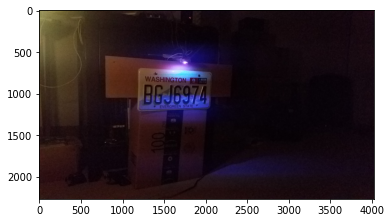

Acc is 99.9916%

ambientlp/amb200_9


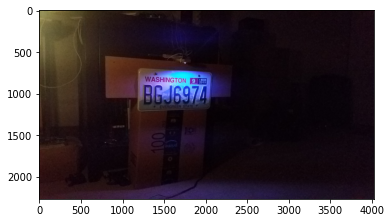

Acc is 99.9959%

ambientlp/amb200_10


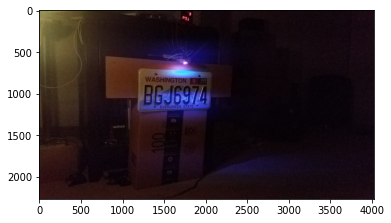

Acc is 99.9959%

ambientlp/amb200_11


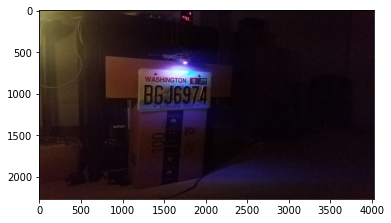

Acc is 47.4174%

ambientlp/amb200_12


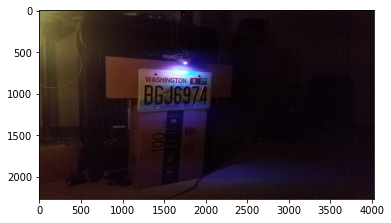

Acc is 92.1822%

ambientlp/amb200_13


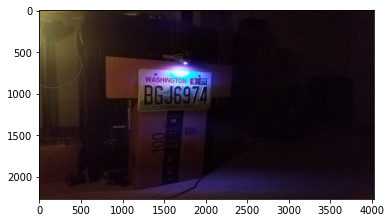

Acc is 63.7064%

ambientlp/amb200_14


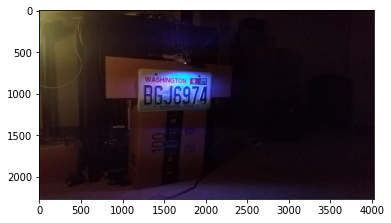

Acc is 99.9969%

ambientlp/amb200_15


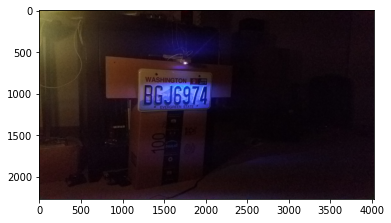

Acc is 99.9979%

ambientlp/amb200_16


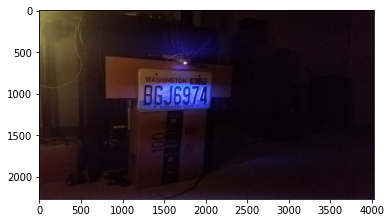

Acc is 99.9982%

ambientlp/amb200_17


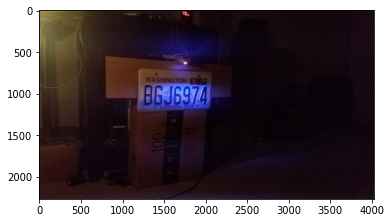

Acc is 99.9981%

ambientlp/amb200_18


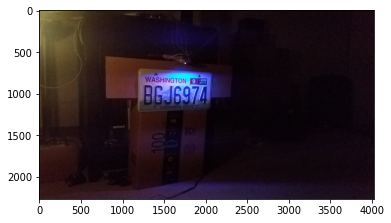

Acc is 99.9961%

ambientlp/amb200_19


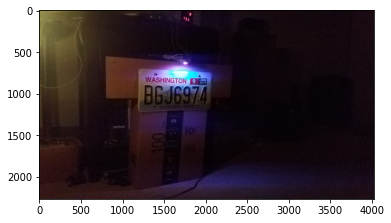

Acc is 0.3755%

ambientlp/amb200_20


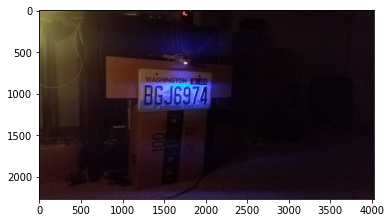

Acc is 99.9977%

ambientlp/amb200_21


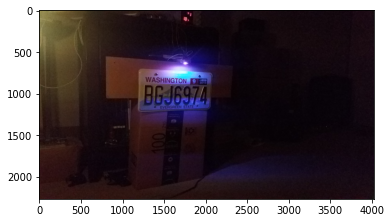

Acc is 99.8276%

ambientlp/amb200_22


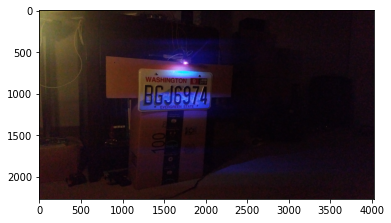

Acc is 99.9944%

ambientlp/amb200_23


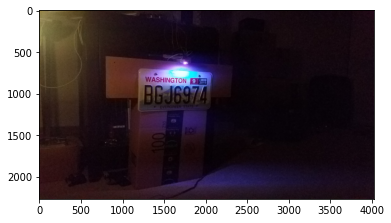

Acc is 1.2158%

ambientlp/amb200_24


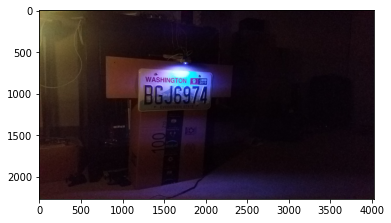

Acc is 99.9521%

ambientlp/amb200_25


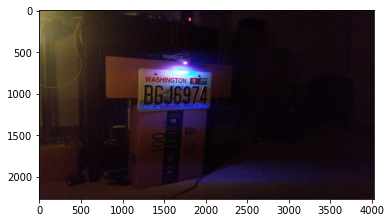

Acc is 13.6812%

ambientlp/amb200_26


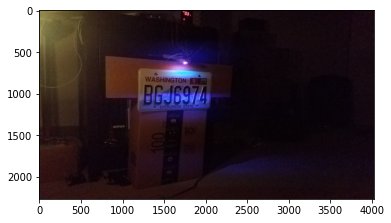

Acc is 99.9926%

ambientlp/amb200_27


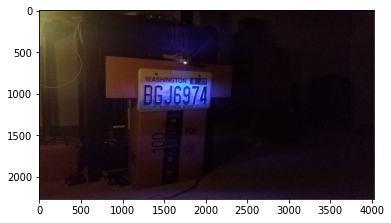

Acc is 99.998%

ambientlp/amb200_28


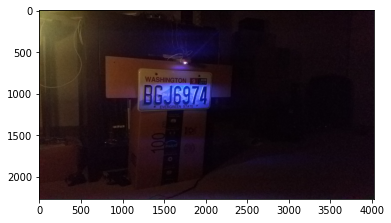

Acc is 99.9979%

ambientlp/amb200_29


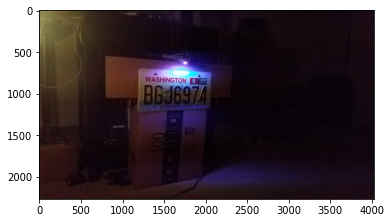

Acc is 28.9965%

ambientlp/amb200_30


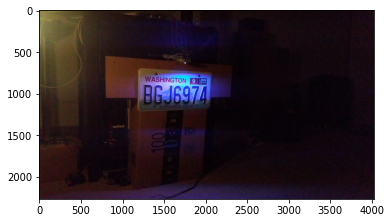

Acc is 99.997%

ambientlp/amb200_31


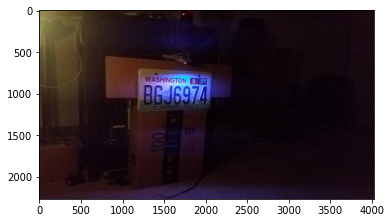

Acc is 99.9973%

ambientlp/amb200_32


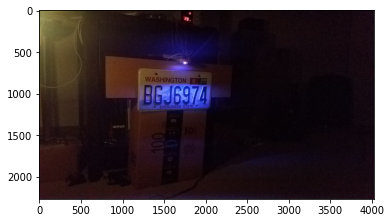

Acc is 99.9974%

ambientlp/amb200_33


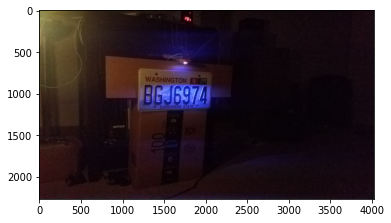

Acc is 99.9974%

ambientlp/amb200_34


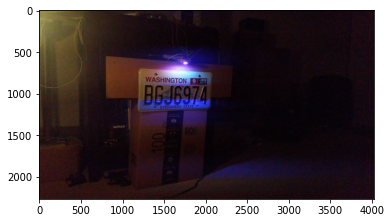

Acc is 98.9751%

ambientlp/amb200_35


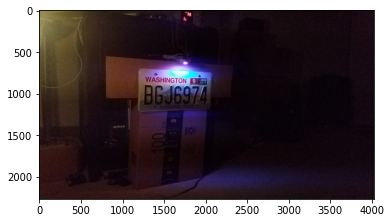

Acc is 1.665%

ambientlp/amb200_36


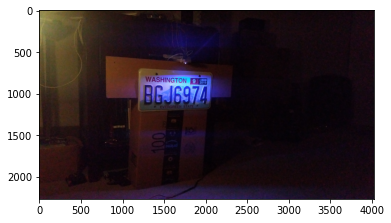

Acc is 99.9978%

ambientlp/amb200_37


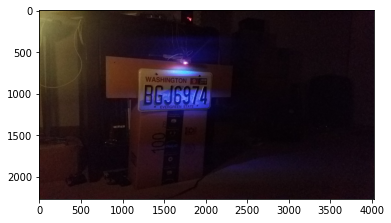

Acc is 99.9965%

ambientlp/amb200_38


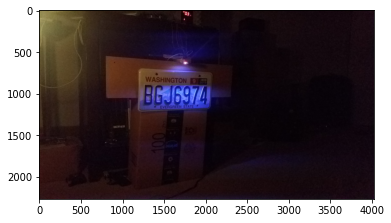

Acc is 99.9961%

ambientlp/amb200_39


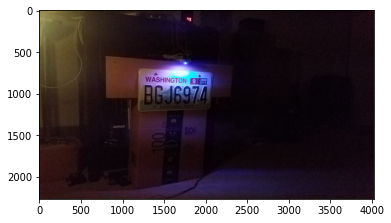

Acc is 64.8%

ambientlp/amb200_40


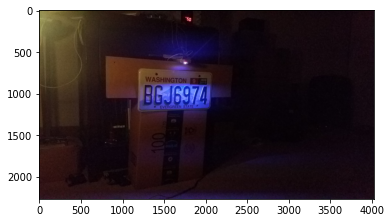

Acc is 99.9974%

ambientlp/amb200_41


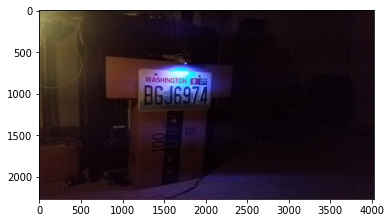

Acc is 99.8283%

ambientlp/amb200_42


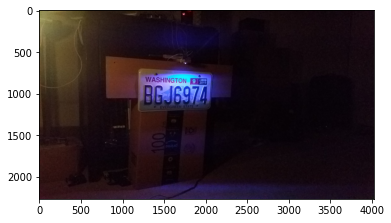

Acc is 99.9962%

ambientlp/amb200_43


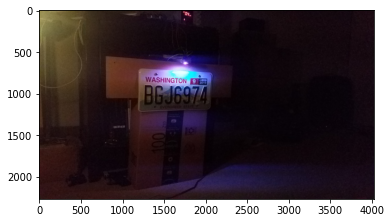

Acc is 12.4338%

ambientlp/amb200_44


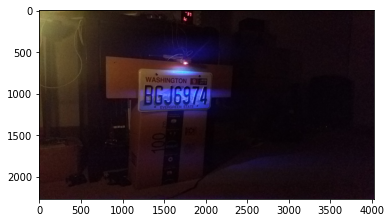

Acc is 99.9951%

ambientlp/amb200_45


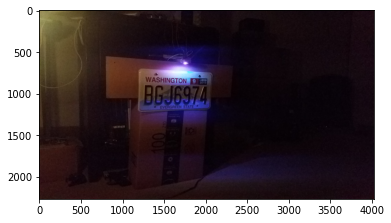

Acc is 99.0298%

ambientlp/amb200_46


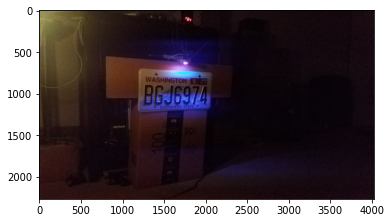

Acc is 99.9934%

ambientlp/amb200_47


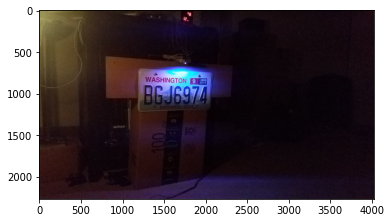

Acc is 99.9922%

ambientlp/amb200_48


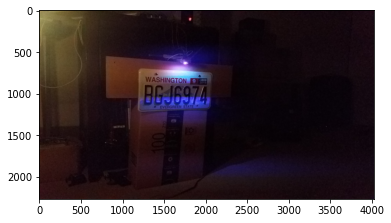

Acc is 99.97%

ambientlp/amb200_49


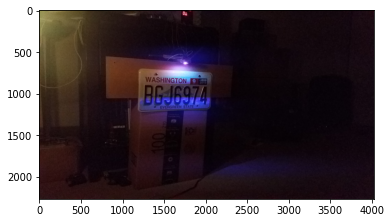

Acc is 99.778%

ambientlp/amb200_50


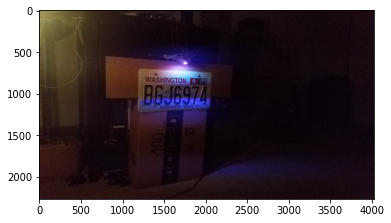

Acc is 99.9568%

ambientlp/amb200_51


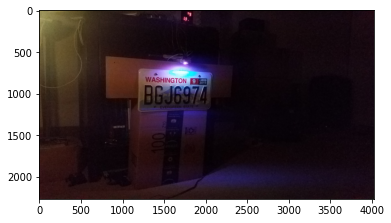

Acc is 0.3308%

ambientlp/amb200_52


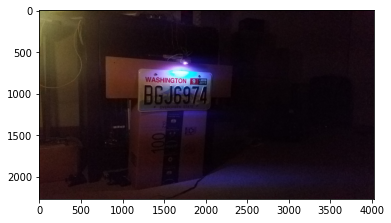

Acc is 2.6103%

ambientlp/amb200_53


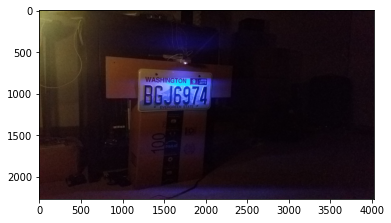

Acc is 99.998%

ambientlp/amb200_54


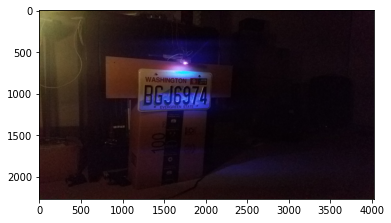

Acc is 99.9919%

ambientlp/amb200_55


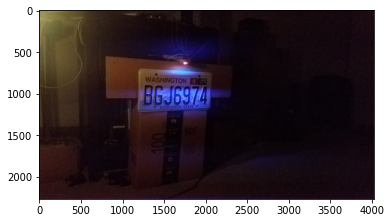

Acc is 99.9944%

ambientlp/amb200_56


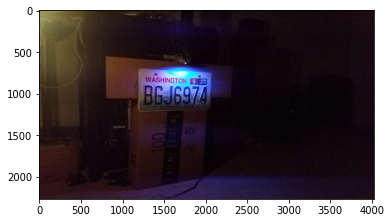

Acc is 99.9876%

ambientlp/amb200_57


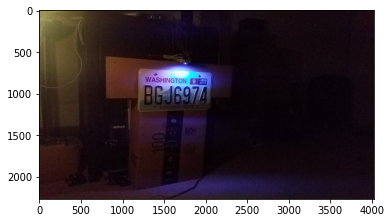

Acc is 97.1099%

ambientlp/amb200_58


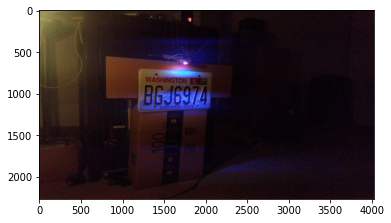

Acc is 99.9975%

ambientlp/amb200_59


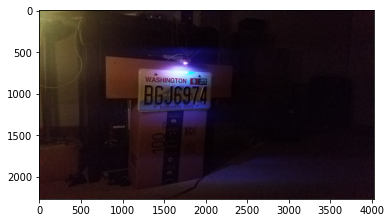

Acc is 10.9993%

ambientlp/amb200_60


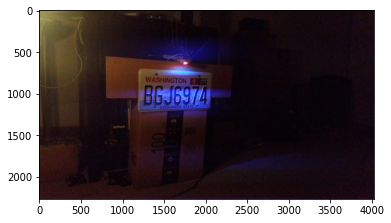

Acc is 99.9933%

ambientlp/amb200_61


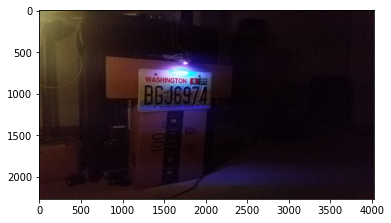

Acc is 89.5849%

ambientlp/amb200_62


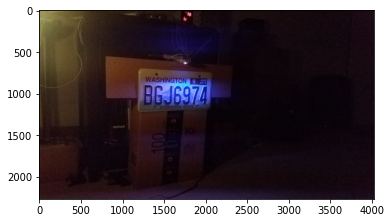

Acc is 99.9971%

ambientlp/amb200_63


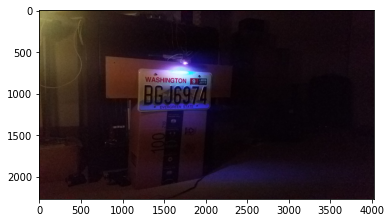

Acc is 14.884%



AttributeError: 'int' object has no attribute 'pop'

In [7]:
#Test Physical. Don't run if you don't have the test images
root = "ambientlp/amb200_"
names = ["lpillum"]
for i in range(64):
    names.append(root + "{}".format(i))
accs = []
dodge = 0
total = -1
rec_chars = []
for name in names:
    print(name)  
    im = name + ".jpg"
    acc, rec = imstat(im,lp_threshold)
    accs.append(acc)
    rec_chars.append(rec)
    if acc < lp_threshold:
        dodge += 1
    total += 1
    
#remove full from stats
accs.pop(0)
rec_chars.pop(0)
print("\n\nAvg Acc: {}%\n".format(round(100*torch.tensor(accs).mean().item(),4)))

print("dodge_success: {:.6}%".format(100 * dodge / total))


In [8]:
rec_chars.pop(0)
print("\n\nAvg Acc: {}%\n".format(round(100*torch.tensor(accs).mean().item(),4)))

print("dodge_success: {:.6}%".format(100 * dodge / total))



Avg Acc: 78.7834%

dodge_success: 21.875%


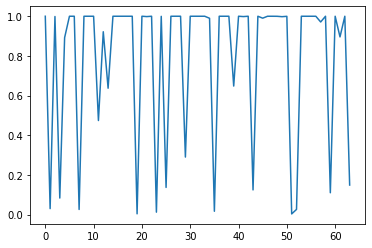

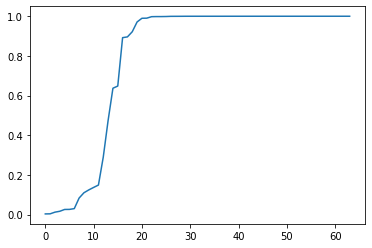

In [7]:
cop = accs
plt.plot(accs)
plt.show()
cop.sort()
plt.plot(cop)
plt.show()

In [31]:
dn.python

AttributeError: module 'darknet' has no attribute 'python'

In [2]:
from ctypes import *


In [3]:
lib = CDLL("C:/Users/setup/Desktop/invis/invis-perturbations/darknet/libdarknet.so", RTLD_GLOBAL)

OSError: [WinError 193] %1 is not a valid Win32 application